# Question 1

In [1]:
!pip install control
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.9 MB/s eta 0:00:00


In [4]:
import numpy as np
import control
import matplotlib.pyplot as plt
from scipy import signal
import skfuzzy as fuzz
from skfuzzy import control as ctrl


In [8]:
# System definition
num = [1]
den = [1, 1]
sys = control.TransferFunction(num, den)

# Adding delay
delay = 0.5
n_pade = 2
num_delay, den_delay = control.pade(delay, n_pade)
sys_delay = control.TransferFunction(num_delay, den_delay)
sys_with_delay = sys * sys_delay

# Simulation time
t = np.linspace(0, 15, 1000)
dt = t[1] - t[0]

# Adding noise and disturbance with reduced parameters
def add_noise_and_disturbance(signal, t, noise_amplitude=0.005, disturbance_time=7):
    # Reduced Gaussian noise
    noise = np.random.normal(0, noise_amplitude, len(t))

    # Step disturbance
    disturbance = np.zeros_like(t)
    disturbance[t >= disturbance_time] = 0.1

    return signal + noise + disturbance


In [9]:
# Performance calculation function
def calculate_performance(y, t, with_noise=True):
    if with_noise:
        window = 10
        y = np.convolve(y, np.ones(window)/window, mode='same')

    steady_state = np.mean(y[-100:])
    settling_time = 0
    peak = max(y)
    rise_time = 0
    overshoot = (peak - steady_state) / steady_state * 100 if steady_state != 0 else 0

    # Calculate settling time (2%)
    steady_state_threshold = 0.02
    for i in range(len(y)):
        if abs(y[i] - steady_state) <= steady_state_threshold * steady_state:
            settling_time = t[i]
            break

    # Calculate rise time (10% to 90%)
    y_normalized = (y - y[0]) / (steady_state - y[0]) if steady_state != y[0] else y
    for i in range(len(y)):
        if y_normalized[i] >= 0.1:
            t1 = t[i]
            break
    for i in range(len(y)):
        if y_normalized[i] >= 0.9:
            t2 = t[i]
            rise_time = t2 - t1
            break

    return {
        'Overshoot (%)': overshoot,
        'Settling Time (s)': settling_time,
        'Rise Time (s)': rise_time,
        'Peak': peak,
        'Steady State': steady_state
    }


In [10]:
# Ziegler-Nichols tuning
def ziegler_nichols_tune(sys):
    gm, pm, wg, wp = control.margin(sys)
    Ku = gm
    Tu = 2*np.pi/wg

    Kp = 0.6 * Ku
    Ti = Tu/2
    Td = Tu/8

    Ki = Kp/Ti
    Kd = Kp*Td

    return Kp, Ki, Kd

# Auto-tuning method
def auto_tune(sys):
    t_temp, y_temp = control.step_response(sys)
    steady_state = y_temp[-1]

    idx_63 = np.where(y_temp >= 0.632 * steady_state)[0][0]
    tau = t_temp[idx_63]

    Kp = 0.6 * tau / (delay * steady_state)
    Ti = tau
    Td = 0.5 * delay

    Ki = Kp / Ti
    Kd = Kp * Td

    return Kp, Ki, Kd

# Tune controllers
Kp_zn, Ki_zn, Kd_zn = ziegler_nichols_tune(sys_with_delay)
pid_zn = control.TransferFunction([Kd_zn, Kp_zn, Ki_zn], [1, 0])
sys_cl_zn = control.feedback(pid_zn * sys_with_delay)

Kp_auto, Ki_auto, Kd_auto = auto_tune(sys_with_delay)
pid_auto = control.TransferFunction([Kd_auto, Kp_auto, Ki_auto], [1, 0])
sys_cl_auto = control.feedback(pid_auto * sys_with_delay)

# Simulate responses
t_zn, y_zn = control.step_response(sys_cl_zn, t)
t_auto, y_auto = control.step_response(sys_cl_auto, t)

# Add noise and disturbance to responses
y_zn_noisy = add_noise_and_disturbance(y_zn, t)
y_auto_noisy = add_noise_and_disturbance(y_auto, t)

# Fuzzy controller
def create_fuzzy_pid():
    error = ctrl.Antecedent(np.linspace(-1, 1, 7), 'error')
    d_error = ctrl.Antecedent(np.linspace(-1, 1, 7), 'delta_error')
    pid_output = ctrl.Consequent(np.linspace(-1, 1, 7), 'output')

    names = ['nb', 'nm', 'ns', 'z', 'ps', 'pm', 'pb']
    error.automf(names=names)
    d_error.automf(names=names)
    pid_output.automf(names=names)

    rules = []
    for i in range(7):
        for j in range(7):
            rules.append(ctrl.Rule(error[names[i]] & d_error[names[j]],
                                 pid_output[names[min(6, max(0, i + j - 3))]]))

    fuzzy_pid = ctrl.ControlSystem(rules)
    return ctrl.ControlSystemSimulation(fuzzy_pid)

# Simulate fuzzy PID
fuzzy_controller = create_fuzzy_pid()
t_fuzzy = t
y_fuzzy = np.zeros_like(t)
error_prev = 0

for i in range(len(t)-1):
    if i == 0:
        error = 1
    else:
        error = 1 - y_fuzzy[i-1]

    d_error = (error - error_prev) / dt

    fuzzy_controller.input['error'] = np.clip(error, -1, 1)
    fuzzy_controller.input['delta_error'] = np.clip(d_error, -1, 1)
    fuzzy_controller.compute()

    y_fuzzy[i+1] = y_fuzzy[i] + fuzzy_controller.output['output'] * dt
    error_prev = error

# Add noise and disturbance to fuzzy response
y_fuzzy_noisy = add_noise_and_disturbance(y_fuzzy, t)


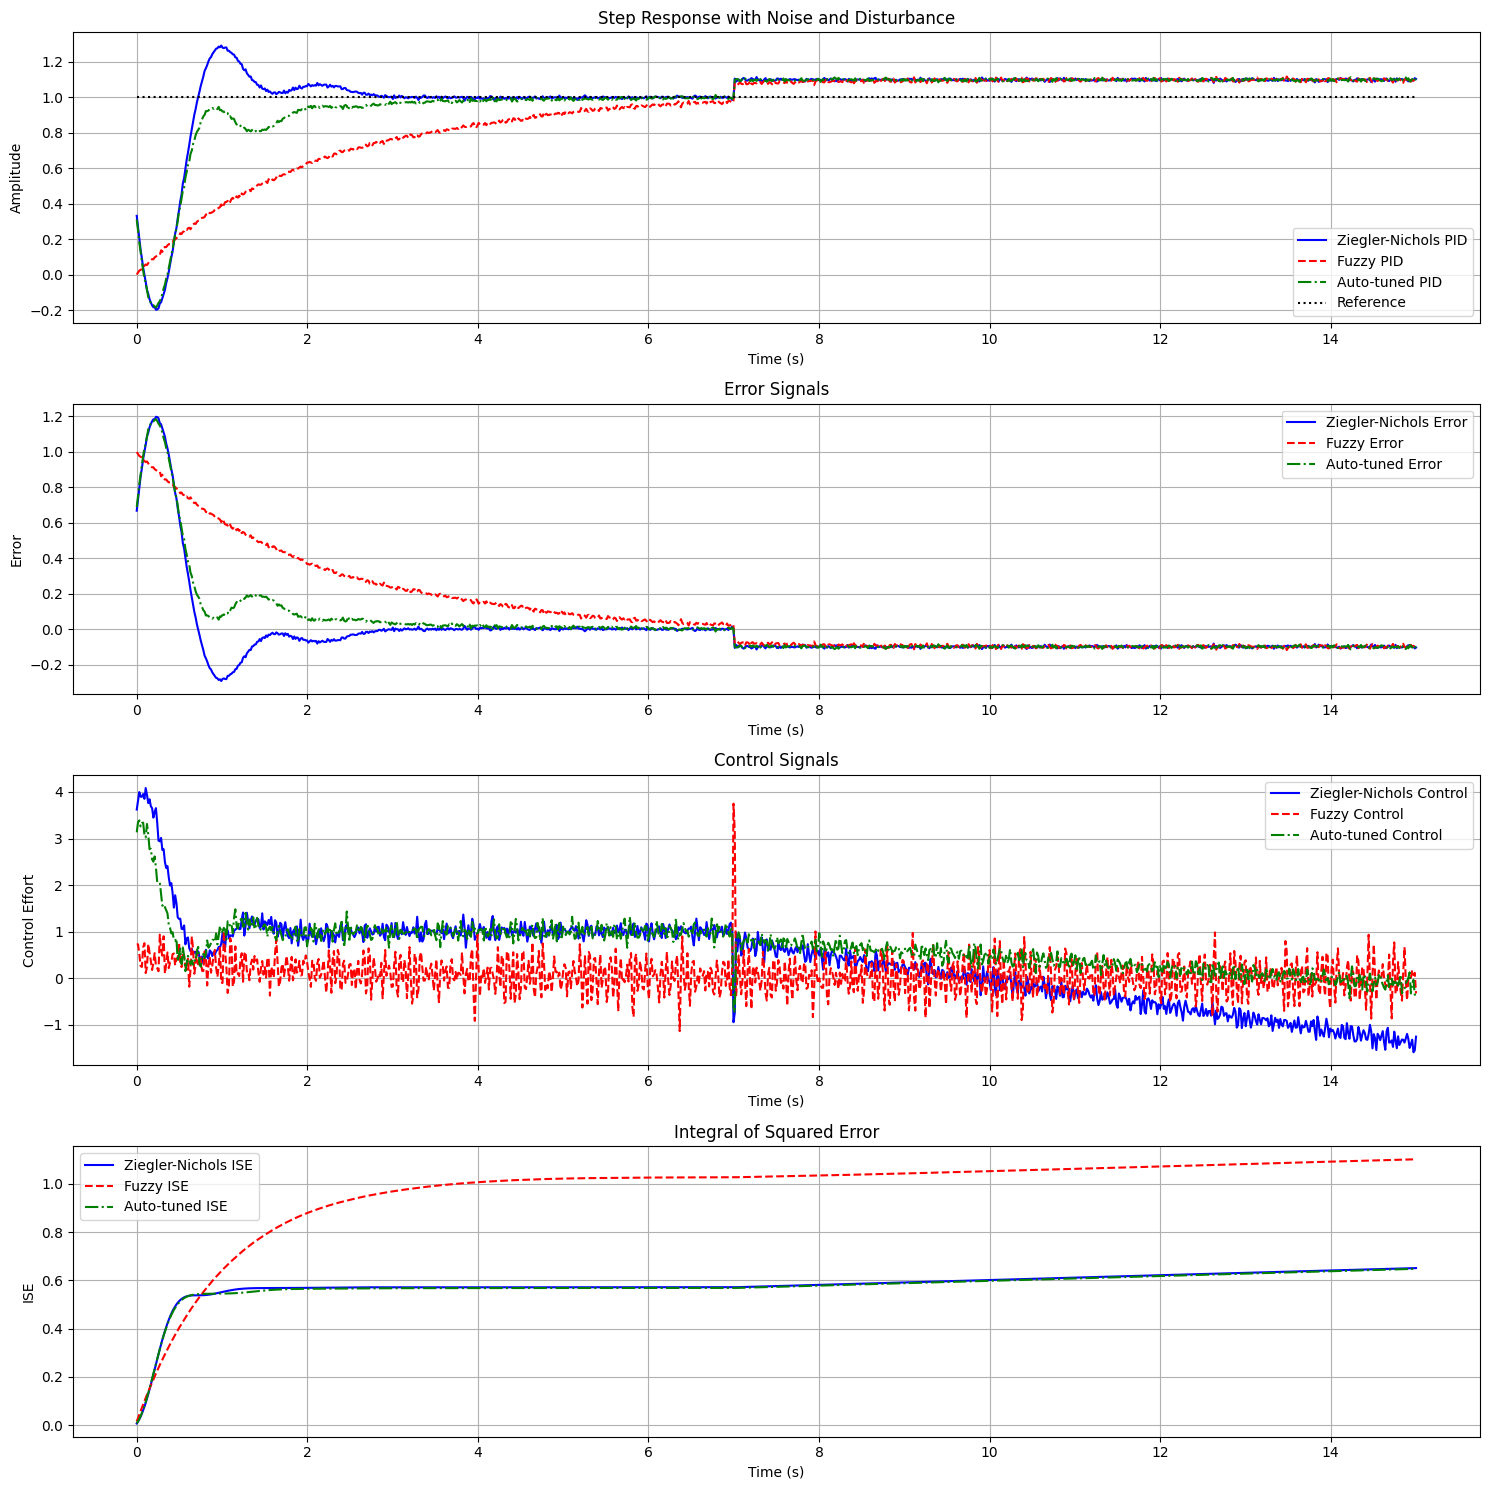


Controller Parameters:

Ziegler-Nichols PID:
Kp = 2.309
Ki = 2.732
Kd = 0.488

Auto-tuned PID:
Kp = 1.827
Ki = 1.202
Kd = 0.457

Performance Metrics:

Ziegler-Nichols PID Performance:
Overshoot (%): 17.653
Settling Time (s): 0.766
Rise Time (s): 0.285
Peak: 1.280
Steady State: 1.088

Fuzzy PID Performance:
Overshoot (%): 1.501
Settling Time (s): 7.072
Rise Time (s): 6.682
Peak: 1.104
Steady State: 1.088

Auto-tuned PID Performance:
Overshoot (%): 1.502
Settling Time (s): 7.042
Rise Time (s): 4.114
Peak: 1.105
Steady State: 1.088


In [11]:
# Plotting
plt.figure(figsize=(15, 15))

# Step response with noise
plt.subplot(411)
plt.plot(t_zn, y_zn_noisy, 'b-', label='Ziegler-Nichols PID')
plt.plot(t_fuzzy, y_fuzzy_noisy, 'r--', label='Fuzzy PID')
plt.plot(t_auto, y_auto_noisy, 'g-.', label='Auto-tuned PID')
plt.plot(t, np.ones_like(t), 'k:', label='Reference')
plt.grid(True)
plt.legend()
plt.title('Step Response with Noise and Disturbance')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Error signals
plt.subplot(412)
error_zn = 1 - y_zn_noisy
error_fuzzy = 1 - y_fuzzy_noisy
error_auto = 1 - y_auto_noisy
plt.plot(t, error_zn, 'b-', label='Ziegler-Nichols Error')
plt.plot(t, error_fuzzy, 'r--', label='Fuzzy Error')
plt.plot(t, error_auto, 'g-.', label='Auto-tuned Error')
plt.grid(True)
plt.legend()
plt.title('Error Signals')
plt.xlabel('Time (s)')
plt.ylabel('Error')

# Control signals
plt.subplot(413)
control_zn = Kp_zn * error_zn + Ki_zn * np.cumsum(error_zn) * dt + Kd_zn * np.gradient(error_zn, dt)
control_fuzzy = np.gradient(y_fuzzy_noisy, dt)
control_auto = Kp_auto * error_auto + Ki_auto * np.cumsum(error_auto) * dt + Kd_auto * np.gradient(error_auto, dt)

plt.plot(t, control_zn, 'b-', label='Ziegler-Nichols Control')
plt.plot(t, control_fuzzy, 'r--', label='Fuzzy Control')
plt.plot(t, control_auto, 'g-.', label='Auto-tuned Control')
plt.grid(True)
plt.legend()
plt.title('Control Signals')
plt.xlabel('Time (s)')
plt.ylabel('Control Effort')

# ISE
plt.subplot(414)
ise_zn = np.cumsum(error_zn**2) * dt
ise_fuzzy = np.cumsum(error_fuzzy**2) * dt
ise_auto = np.cumsum(error_auto**2) * dt
plt.plot(t, ise_zn, 'b-', label='Ziegler-Nichols ISE')
plt.plot(t, ise_fuzzy, 'r--', label='Fuzzy ISE')
plt.plot(t, ise_auto, 'g-.', label='Auto-tuned ISE')
plt.grid(True)
plt.legend()
plt.title('Integral of Squared Error')
plt.xlabel('Time (s)')
plt.ylabel('ISE')

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nController Parameters:")
print("\nZiegler-Nichols PID:")
print(f"Kp = {Kp_zn:.3f}")
print(f"Ki = {Ki_zn:.3f}")
print(f"Kd = {Kd_zn:.3f}")

print("\nAuto-tuned PID:")
print(f"Kp = {Kp_auto:.3f}")
print(f"Ki = {Ki_auto:.3f}")
print(f"Kd = {Kd_auto:.3f}")

print("\nPerformance Metrics:")
zn_metrics = calculate_performance(y_zn_noisy, t)
fuzzy_metrics = calculate_performance(y_fuzzy_noisy, t)
auto_metrics = calculate_performance(y_auto_noisy, t)

print("\nZiegler-Nichols PID Performance:")
for key, value in zn_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nFuzzy PID Performance:")
for key, value in fuzzy_metrics.items():
    print(f"{key}: {value:.3f}")

print("\nAuto-tuned PID Performance:")
for key, value in auto_metrics.items():
    print(f"{key}: {value:.3f}")

# Question 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def machine(fi, x):
    sum1 = 0
    sum2 = 0

    # Define lookup tables
    y = np.array([
        [-26.6, -40,    0,    0,    0],
        [-26.6, -40,  -40,  -40,  -40],
        [ 13.3,-13.3,-26.6, -40,-26.6],
        [ 26.6, 26.6,   0,-26.6,-26.6],
        [ 26.6,  40, 26.6, 13.3,-13.3],
        [    0,  40,   40,   40, 26.6],
        [    0,   0,    0,   40, 26.6]
    ])

    t = np.array([
        [1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 0, 0, 1, 1]
    ])

    a = -45
    for i in range(7):
        if abs(fi - a) <= 45:
            r = 1 - (abs(fi - a) / 45)
        else:
            r = 0
        a += 45

        b = 2
        for j in range(5):
            if abs(x - b) <= 4:
                s = 1 - (abs(x - b) / 4)
            else:
                s = 0
            b += 4

            c1 = r * s * y[i,j]
            sum1 += c1
            c2 = r * s * t[i,j]
            sum2 += c2

    return sum1/sum2 if sum2 != 0 else 0

def func1(u):
    u = u * (np.pi/180)
    return np.cos(u)

def func2(fi, teta):
    fi = fi * (np.pi/180)
    teta = teta * (np.pi/180)
    return np.sin(fi) * np.sin(teta)

def func3(u):
    u = u * (np.pi/180)
    return np.sin(u)

def func4(fi, teta):
    fi = fi * (np.pi/180)
    teta = teta * (np.pi/180)
    return np.cos(fi) * np.sin(teta)

def fanc5(teta):
    teta = teta * (np.pi/180)
    teta = np.arcsin(0.5 * np.sin(teta))
    return (180/np.pi) * teta

def car_model(x, y, phi, theta):
    """Simulate one step of the car model"""
    x_next = x + func1(phi + theta) + func2(phi, theta)
    y_next = y + func1(phi + theta) - func4(phi, theta)
    phi_next = phi - fanc5(theta)
    return x_next, y_next, phi_next

def draw_car(ax, x, y, phi, color='blue'):
    """Draw car"""
    # Convert phi to radians for calculations
    phi_rad = phi * np.pi / 180

    # Car dimensions
    car_length = 0.5
    car_width = 0.3

    # Calculate car corners (rectangle)
    back_x = x - car_length/2 * np.cos(phi_rad)
    back_y = y - car_length/2 * np.sin(phi_rad)
    front_x = x + car_length/2 * np.cos(phi_rad)
    front_y = y + car_length/2 * np.sin(phi_rad)

    # Draw car body (line from back to front)
    ax.plot([back_x, front_x], [back_y, front_y], color=color, linewidth=2)

    # Draw back indicator (circle)
    ax.plot(back_x, back_y, 'ro', markersize=8)

    # Draw front indicator (triangle)
    ax.plot(front_x, front_y, 'b^', markersize=8)


In [ ]:
# Get initial conditions from user
print("Please enter initial conditions:")
print("Note: x should be between 0 and 20, phi should be in degrees")

while True:
    try:
        x = float(input("Enter initial x position (0-20): "))
        if 0 <= x <= 20:
            break
        else:
            print("X must be between 0 and 20")
    except ValueError:
        print("Please enter a valid number")

while True:
    try:
        phi = float(input("Enter initial angle in degrees: "))
        break
    except ValueError:
        print("Please enter a valid number")


Please enter initial conditions:
Note: x should be between 0 and 20, phi should be in degrees
Enter initial x position (0-20): 16
Enter initial angle in degrees: 30


In [ ]:
# Initial y position
y = 0

# Target conditions
target_x = 10
target_phi = 90

# Simulation parameters
max_steps = 1000
tolerance = 0.1

# Arrays to store trajectory
x_trajectory = [x]
y_trajectory = [y]
phi_trajectory = [phi]

# Main simulation loop
for step in range(max_steps):
    theta = machine(phi, x)
    x_new, y_new, phi_new = car_model(x, y, phi, theta)

    x_trajectory.append(x_new)
    y_trajectory.append(y_new)
    phi_trajectory.append(phi_new)

    x, y, phi = x_new, y_new, phi_new

    if abs(target_x - x) < tolerance and abs(target_phi - phi) < tolerance:
        break


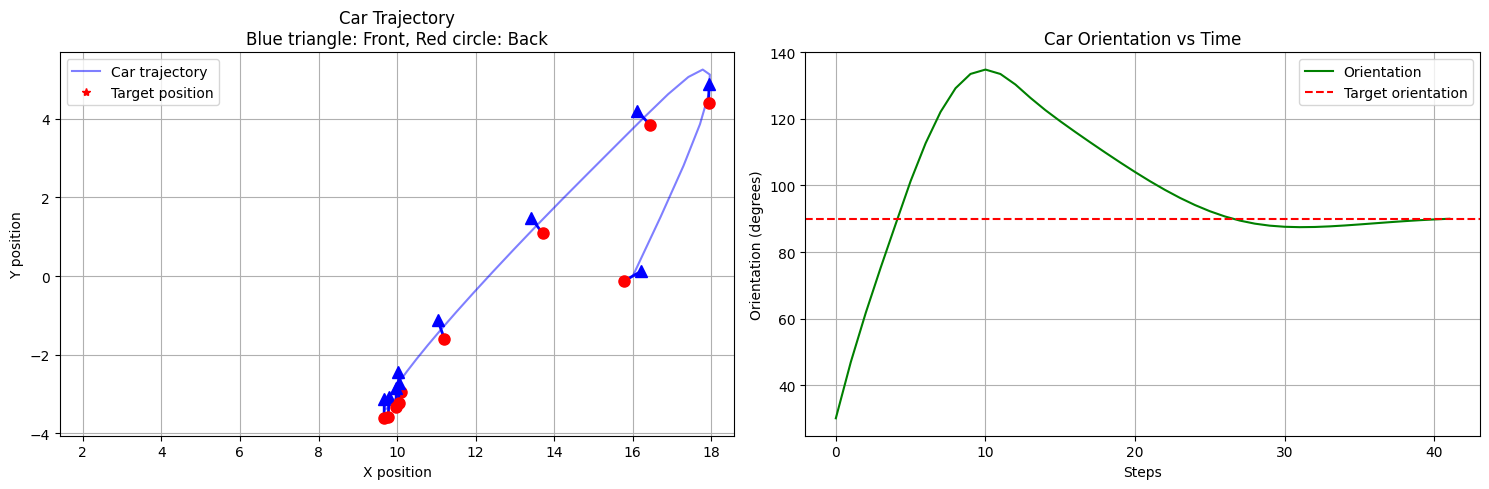


Simulation Results:
Final position: x = 10.04, y = -2.98
Final angle: 89.99 degrees
Steps taken: 41


In [ ]:
# Create visualization
plt.figure(figsize=(15, 5))

# Trajectory plot with car indicators
plt.subplot(121)
plt.plot(x_trajectory, y_trajectory, 'b-', label='Car trajectory', alpha=0.5)
plt.plot(target_x, y_trajectory[-1], 'r*', label='Target position')

# Draw cars at intervals along the trajectory
num_indicators = min(10, len(x_trajectory))
indices = np.linspace(0, len(x_trajectory)-1, num_indicators, dtype=int)
for i in indices:
    draw_car(plt.gca(), x_trajectory[i], y_trajectory[i], phi_trajectory[i])

plt.grid(True)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Car Trajectory\nBlue triangle: Front, Red circle: Back')
plt.legend()
plt.axis('equal')
plt.xlim(0, 20)

# Orientation plot
plt.subplot(122)
steps = range(len(phi_trajectory))
plt.plot(steps, phi_trajectory, 'g-', label='Orientation')
plt.axhline(y=target_phi, color='r', linestyle='--', label='Target orientation')
plt.grid(True)
plt.xlabel('Steps')
plt.ylabel('Orientation (degrees)')
plt.title('Car Orientation vs Time')
plt.legend()

plt.tight_layout()
plt.show()

# Print final state
print(f"\nSimulation Results:")
print(f"Final position: x = {x:.2f}, y = {y:.2f}")
print(f"Final angle: {phi:.2f} degrees")
print(f"Steps taken: {step + 1}")

# Question 3

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1wFACOPiTrxrE_Gj8oe9YZx98Fm8U8jXI

Downloading...
From: https://drive.google.com/uc?id=1wFACOPiTrxrE_Gj8oe9YZx98Fm8U8jXI
To: /content/steamgen.dat
100% 2.26M/2.26M [00:00<00:00, 74.2MB/s]


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
def load_and_preprocess_data(filename):
    try:
        data = pd.read_csv(filename, delimiter='\s+', header=None)
        data.columns = ['time', 'fuel', 'air', 'level_ref', 'disturbance',
                       'drum_pressure', 'excess_oxygen', 'water_level', 'steam_flow']

        X = data[['fuel', 'air', 'level_ref', 'disturbance']].values
        y = data[['drum_pressure', 'excess_oxygen', 'water_level', 'steam_flow']].values

        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)

        return X_scaled, y_scaled, scaler_X, scaler_y

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None, None

# Load and preprocess data
    X, y, scaler_X, scaler_y = load_and_preprocess_data('steamgen.dat')

    if X is None:
        print("Failed to load data. Please check if the file exists and is correctly formatted.")
        exit()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)



In [ ]:
class MembershipFunction:
    def __init__(self, mf_type='gaussian'):
        self.mf_type = mf_type
        self.params = None

    def gaussian(self, x, mean, sigma):
        return np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))

    def initialize_params(self, input_range):
        if self.mf_type == 'gaussian':
            min_val, max_val = input_range
            range_val = max_val - min_val
            mean = min_val + range_val/2
            sigma = range_val/4
            self.params = np.array([mean, sigma])

    def membership_value(self, x):
        if self.mf_type == 'gaussian':
            return self.gaussian(x, self.params[0], self.params[1])

class ANFISLayer:
    def __init__(self, n_inputs, n_mfs, mf_type='gaussian'):
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.membership_functions = []

        for i in range(n_inputs):
            input_mfs = []
            for j in range(n_mfs):
                mf = MembershipFunction(mf_type)
                input_mfs.append(mf)
            self.membership_functions.append(input_mfs)

    def initialize_parameters(self, X):
        for i in range(self.n_inputs):
            input_range = (np.min(X[:, i]), np.max(X[:, i]))
            for mf in self.membership_functions[i]:
                mf.initialize_params(input_range)

    def forward(self, X):
        batch_size = X.shape[0]
        membership_values = np.zeros((batch_size, self.n_inputs, self.n_mfs))

        for i in range(self.n_inputs):
            for j in range(self.n_mfs):
                membership_values[:, i, j] = self.membership_functions[i][j].membership_value(X[:, i])

        return membership_values

class ANFIS:
    def __init__(self, n_inputs, n_mfs, learning_rate=0.01):
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.learning_rate = learning_rate

        self.fuzzification = ANFISLayer(n_inputs, n_mfs)
        self.n_rules = n_mfs ** n_inputs
        self.consequent_params = np.random.randn(self.n_rules, n_inputs + 1) * 0.1

    def initialize(self, X):
        self.fuzzification.initialize_parameters(X)

    def forward(self, X):
        batch_size = X.shape[0]

        # Layer 1: Fuzzification
        membership_values = self.fuzzification.forward(X)

        # Layer 2: Rules
        firing_strengths = np.ones((batch_size, self.n_rules))
        rule_idx = 0
        for idx in np.ndindex(*[self.n_mfs] * self.n_inputs):
            current_strength = np.ones(batch_size)
            for input_idx, mf_idx in enumerate(idx):
                current_strength *= membership_values[:, input_idx, mf_idx]
            firing_strengths[:, rule_idx] = current_strength
            rule_idx += 1

        # Layer 3: Normalize firing strengths
        sum_firing = np.sum(firing_strengths, axis=1, keepdims=True)
        normalized_firing = firing_strengths / (sum_firing + 1e-10)

        # Layer 4: Consequent parameters
        X_aug = np.column_stack([X, np.ones(batch_size)])
        rule_outputs = np.dot(X_aug, self.consequent_params.T)

        # Layer 5: Output
        output = np.sum(normalized_firing * rule_outputs, axis=1)

        return output, normalized_firing, X_aug

    def train(self, X, y, epochs=100, batch_size=32):
        self.initialize(X)
        n_samples = X.shape[0]
        history = []

        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            total_loss = 0

            for start_idx in range(0, n_samples, batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]

                # Forward pass
                y_pred, normalized_firing, X_aug = self.forward(X_batch)
                loss = np.mean((y_batch - y_pred) ** 2)
                total_loss += loss

                # Backward pass
                error = y_batch - y_pred
                error = error.reshape(-1, 1)  # Reshape error for broadcasting

                # Update consequent parameters
                for i in range(self.n_rules):
                    normalized_firing_i = normalized_firing[:, i:i+1]
                    gradient = -2 * np.mean(error * normalized_firing_i * X_aug, axis=0)
                    self.consequent_params[i] -= self.learning_rate * gradient

            avg_loss = total_loss / (n_samples / batch_size)
            history.append(avg_loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

        return history

    def predict(self, X):
        output, _, _ = self.forward(X)
        return output


In [ ]:
# Train models for each output
models = []
histories = []
predictions = []

for i in range(y_train.shape[1]):
    print(f"\nTraining model for output {i+1}")
    model = ANFIS(n_inputs=4, n_mfs=2, learning_rate=0.01)
    history = model.train(X_train, y_train[:, i], epochs=100, batch_size=32)

    models.append(model)
    histories.append(history)
    predictions.append(model.predict(X_test))

# Combine predictions
y_pred = np.column_stack(predictions)


Training model for output 1
Epoch 0, Loss: 0.200016
Epoch 10, Loss: 0.043392
Epoch 20, Loss: 0.037164
Epoch 30, Loss: 0.033206
Epoch 40, Loss: 0.030678
Epoch 50, Loss: 0.029053
Epoch 60, Loss: 0.028003
Epoch 70, Loss: 0.027319
Epoch 80, Loss: 0.026870
Epoch 90, Loss: 0.026572

Training model for output 2
Epoch 0, Loss: 0.120592
Epoch 10, Loss: 0.064616
Epoch 20, Loss: 0.053728
Epoch 30, Loss: 0.046956
Epoch 40, Loss: 0.042731
Epoch 50, Loss: 0.040086
Epoch 60, Loss: 0.038421
Epoch 70, Loss: 0.037368
Epoch 80, Loss: 0.036697
Epoch 90, Loss: 0.036266

Training model for output 3
Epoch 0, Loss: 0.146717
Epoch 10, Loss: 0.011443
Epoch 20, Loss: 0.010982
Epoch 30, Loss: 0.010687
Epoch 40, Loss: 0.010497
Epoch 50, Loss: 0.010374
Epoch 60, Loss: 0.010295
Epoch 70, Loss: 0.010244
Epoch 80, Loss: 0.010210
Epoch 90, Loss: 0.010189

Training model for output 4
Epoch 0, Loss: 0.164940
Epoch 10, Loss: 0.037845
Epoch 20, Loss: 0.030619
Epoch 30, Loss: 0.026054
Epoch 40, Loss: 0.023140
Epoch 50, Los

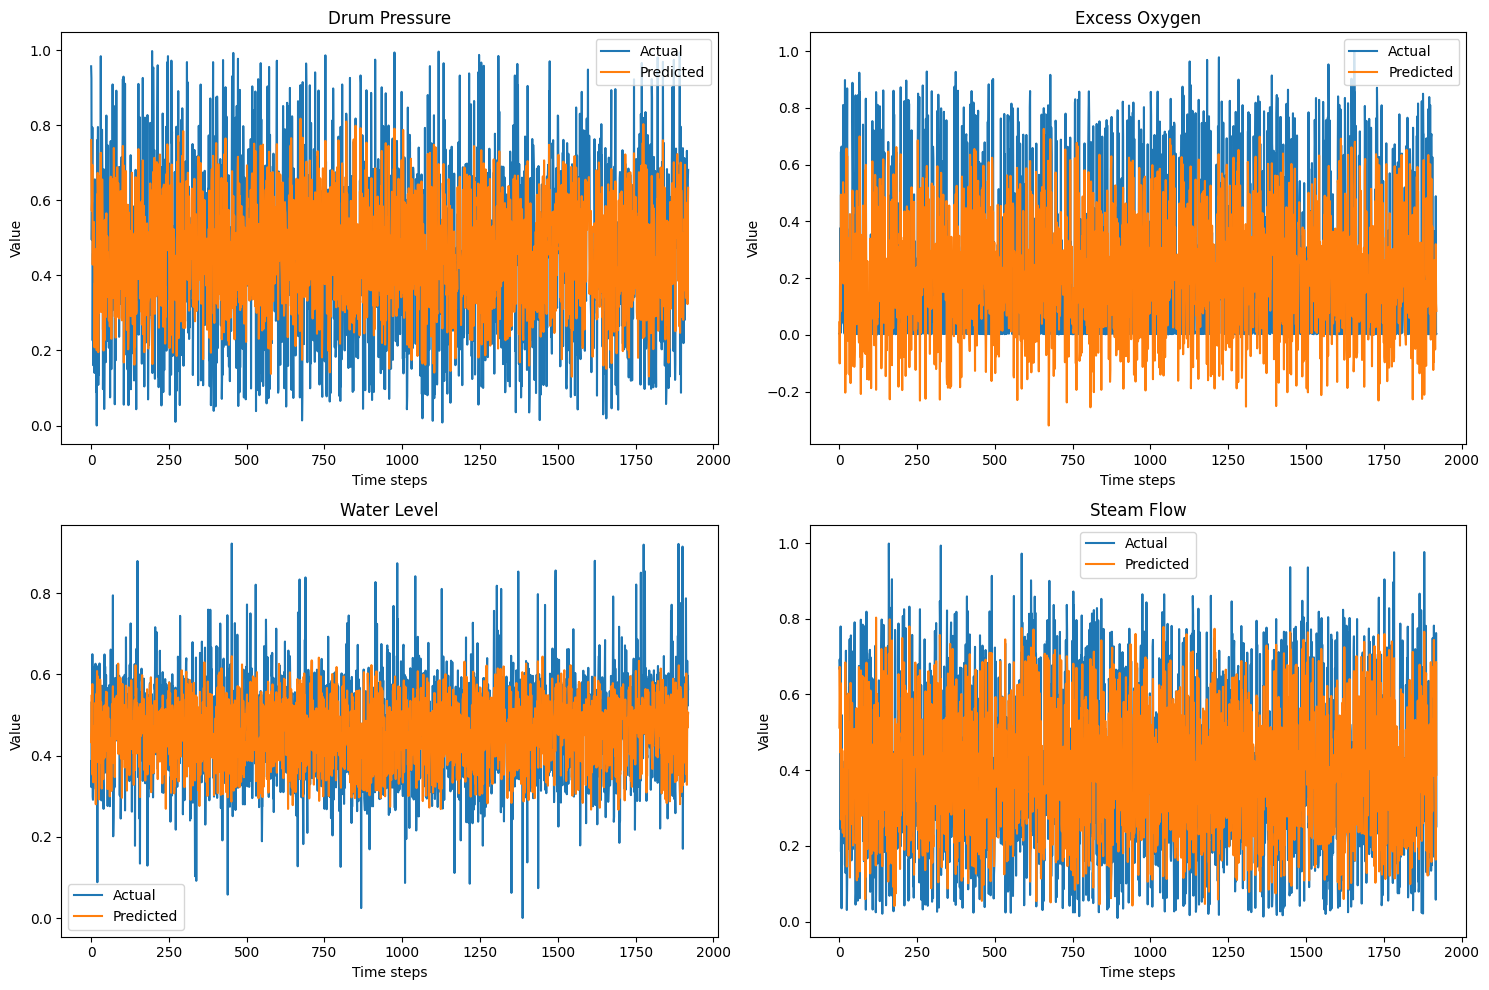


Model Performance Metrics:

Drum Pressure:
MSE: 0.026991
RMSE: 0.164290
R²: 0.465384

Excess Oxygen:
MSE: 0.034954
RMSE: 0.186961
R²: 0.585755

Water Level:
MSE: 0.010250
RMSE: 0.101241
R²: 0.386818

Steam Flow:
MSE: 0.018411
RMSE: 0.135687
R²: 0.664384


In [ ]:
# Calculate metrics
mse = np.mean((y_test - y_pred) ** 2, axis=0)
rmse = np.sqrt(mse)
r2 = 1 - np.sum((y_test - y_pred) ** 2, axis=0) / np.sum((y_test - np.mean(y_test, axis=0)) ** 2, axis=0)

# Plot results
output_names = ['Drum Pressure', 'Excess Oxygen', 'Water Level', 'Steam Flow']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (ax, name) in enumerate(zip(axes, output_names)):
    ax.plot(y_test[:, i], label='Actual')
    ax.plot(y_pred[:, i], label='Predicted')
    ax.set_title(f'{name}')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

# Print metrics
print("\nModel Performance Metrics:")
for i, name in enumerate(output_names):
    print(f"\n{name}:")
    print(f"MSE: {mse[i]:.6f}")
    print(f"RMSE: {rmse[i]:.6f}")
    print(f"R²: {r2[i]:.6f}")

# Question 4

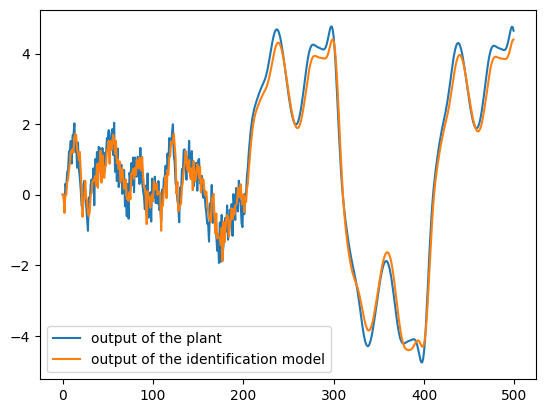

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def calc_g(x):
    return 0.6*np.sin(pi*x) + 0.3*np.sin(3*pi*x) + 0.1*np.sin(5*pi*x)

M = 5
epoch = 200
total_num = 500

x_bar = np.zeros((epoch, M))
g_bar = np.zeros((epoch, M))
sigma = np.zeros((epoch, M))

y = np.zeros((total_num, 1))
x = np.zeros((total_num, 1))
y_hat = np.zeros((total_num, 1))
f_hat = np.zeros((total_num, 1))
z = np.zeros(M)
g_u = np.zeros((total_num, 1))
x[0] = -1 + (2*np.random.randn(1, 1))
y[0] = 0

g_u[0] = calc_g(x[0][0])
f_hat[0] = g_u[0]

u_min = -1
u_max = 1
h = (u_max - u_min)/(M - 1)

# Initialize centers and widths
for k in range(0, M):
    x_bar[0, k] = -1 + h*(k - 1)

maxi = np.max(x_bar[0, :])
mini = np.min(x_bar[0, :])

for k in range(0, M):
    sigma[0, k] = (maxi - mini)/(M)

# Build matrices for batch least squares
Phi = np.zeros((epoch, M))
Y = np.zeros(epoch)

# Collect data for least squares
for q in range(0, epoch):
    x[q] = -1 + (2*np.random.randn(1, 1))
    g_u[q] = calc_g(x[q][0])

    # Calculate basis functions
    b = 0
    for l in range(0, M):
        z[l] = np.exp(-((x[q][0] - x_bar[0, l])**2) / (sigma[0, l]**2))
        b += z[l]

    # Store normalized basis functions
    Phi[q, :] = z / b if b != 0 else z
    Y[q] = g_u[q][0]

# Solve least squares equation: (Phi^T Phi) theta = Phi^T Y
theta = np.linalg.solve(Phi.T @ Phi + 1e-6 * np.eye(M), Phi.T @ Y)

# Store the parameters
for k in range(0, M):
    g_bar[0:epoch, k] = theta[k]
    x_bar[1:epoch, k] = x_bar[0, k]
    sigma[1:epoch, k] = sigma[0, k]

# Calculate model output during training
for q in range(1, epoch - 1):
    b = 0
    a = 0
    for l in range(0, M):
        z[l] = np.exp(-((x[q][0] - x_bar[q, l])**2) / (sigma[q, l]**2))
        b += z[l]
        a += g_bar[q, l]*z[l]

    f_hat[q] = a / b if b != 0 else a
    y[q + 1] = 0.3*y[q] + 0.6*y[q - 1] + g_u[q]
    y_hat[q + 1] = 0.3*y[q] + 0.6*y[q - 1] + f_hat[q]

# Test phase
for q in range(epoch, total_num - 1):
    a = 0
    b = 0
    x[q] = np.sin(2*q*pi/200)
    g_u[q] = calc_g(x[q][0])

    for l in range(0, M):
        z[l] = np.exp(-((x[q][0] - x_bar[epoch-1, l])**2) / (sigma[epoch-1, l]**2))
        b += z[l]
        a += g_bar[epoch-1, l]*z[l]

    f_hat[q] = a / b if b != 0 else a
    y[q + 1] = 0.3*y[q] + 0.6*y[q - 1] + g_u[q]
    y_hat[q + 1] = 0.3*y[q] + 0.6*y[q - 1] + f_hat[q]

plt.plot(y, label='output of the plant')
plt.plot(y_hat, label='output of the identification model')
plt.legend()
plt.show()

# Question 5

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 16uQHNpeXDeiqrlaaINrlvCjLaymJc2DA

Downloading...
From: https://drive.google.com/uc?id=16uQHNpeXDeiqrlaaINrlvCjLaymJc2DA
To: /content/AirQualityUCI.xlsx
100% 1.30M/1.30M [00:00<00:00, 185MB/s]


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_excel('AirQualityUCI.xlsx')

In [ ]:
# Data preprocessing function
def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.strftime('%H:%M:%S')
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    df['Hour'] = df['DateTime'].dt.hour
    df['Day'] = df['DateTime'].dt.day
    df['Month'] = df['DateTime'].dt.month
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek

    df = df.drop(['Date', 'Time', 'DateTime'], axis=1)
    df = df.replace(-200, np.nan)
    df = df.fillna(df.mean())

    return df

df_processed = preprocess_data(df)

# Prepare features and target
X = df_processed.drop('NO2(GT)', axis=1).values
y = df_processed['NO2(GT)'].values

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Split data (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=3)

print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 5613
Validation set size: 1872
Test set size: 1872


In [ ]:
# Custom RBF Layer
class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                     shape=(self.units, input_shape[-1]),
                                     initializer='random_uniform',
                                     trainable=True)
        self.built = True

    def call(self, inputs):
        diff = tf.expand_dims(inputs, axis=1) - self.centers
        sq_diff = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.gamma * sq_diff)

def create_rbf_model(input_dim, rbf_units=1000, gamma=1.0):
    inputs = Input(shape=(input_dim,))
    rbf_layer = RBFLayer(units=rbf_units, gamma=gamma)(inputs)
    output = Dense(1)(rbf_layer)
    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train RBF model
print("\nTraining RBF Network...")
rbf_model = create_rbf_model(input_dim=X_train.shape[1], rbf_units=100, gamma=0.1)

# Create callback to store losses
class LossHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {logs["loss"]:.4f}, Val Loss = {logs["val_loss"]:.4f}')

history = LossHistory()

# Train RBF model
rbf_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[history]
)




Training RBF Network...
Epoch 0: Train Loss = 0.7518, Val Loss = 0.6283
Epoch 10: Train Loss = 0.4444, Val Loss = 0.4817
Epoch 20: Train Loss = 0.3529, Val Loss = 0.3949
Epoch 30: Train Loss = 0.2784, Val Loss = 0.3149
Epoch 40: Train Loss = 0.2453, Val Loss = 0.2838
Epoch 50: Train Loss = 0.2299, Val Loss = 0.2667
Epoch 60: Train Loss = 0.2163, Val Loss = 0.2541
Epoch 70: Train Loss = 0.2035, Val Loss = 0.2402
Epoch 80: Train Loss = 0.1925, Val Loss = 0.2294
Epoch 90: Train Loss = 0.1832, Val Loss = 0.2171


In [ ]:
# ANFIS implementation
class ANFIS:
    def __init__(self, n_rules=5, learning_rate=0.01):
        self.n_rules = n_rules
        self.learning_rate = learning_rate
        self.centers = None
        self.widths = None
        self.consequent_params = None
        self.train_losses = []
        self.val_losses = []

    def gaussian_membership(self, x):
        return np.exp(-0.5 * ((x[:, np.newaxis, :] - self.centers) / self.widths) ** 2)

    def forward_pass(self, X):
        membership_values = self.gaussian_membership(X)
        firing_strengths = np.prod(membership_values, axis=2)
        normalized_firing_strengths = firing_strengths / (np.sum(firing_strengths, axis=1, keepdims=True) + 1e-10)

        X_aug = np.c_[X, np.ones(X.shape[0])]
        consequents = np.array([X_aug @ self.consequent_params[i].T for i in range(self.n_rules)]).T

        return np.sum(normalized_firing_strengths * consequents, axis=1)

    def fit(self, X_train, y_train, X_val, y_val, epochs=200):
        self.train_losses = []
        self.val_losses = []

        idx = np.random.permutation(X_train.shape[0])[:self.n_rules]
        self.centers = X_train[idx]
        self.widths = np.std(X_train, axis=0) * np.ones_like(self.centers)
        self.consequent_params = np.random.randn(self.n_rules, X_train.shape[1] + 1)

        for epoch in range(epochs):
            # Forward pass
            y_pred_train = self.forward_pass(X_train)
            train_loss = mean_squared_error(y_train, y_pred_train)
            self.train_losses.append(train_loss)

            y_pred_val = self.forward_pass(X_val)
            val_loss = mean_squared_error(y_val, y_pred_val)
            self.val_losses.append(val_loss)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

            # Backward pass
            error = y_train - y_pred_train
            membership_values = self.gaussian_membership(X_train)
            firing_strengths = np.prod(membership_values, axis=2)
            normalized_firing_strengths = firing_strengths / (np.sum(firing_strengths, axis=1, keepdims=True) + 1e-10)

            X_aug = np.c_[X_train, np.ones(X_train.shape[0])]
            for i in range(self.n_rules):
                gradient = normalized_firing_strengths[:, i, np.newaxis] * X_aug * error[:, np.newaxis]
                self.consequent_params[i] += self.learning_rate * gradient.mean(axis=0)

    def predict(self, X):
        return self.forward_pass(X)

# Train ANFIS model
print("\nTraining ANFIS...")
anfis_model = ANFIS(n_rules=5, learning_rate=0.1)
anfis_model.fit(X_train, y_train, X_val, y_val, epochs=500)



Training ANFIS...
Epoch 0: Train Loss = 10.9543, Val Loss = 11.6422
Epoch 10: Train Loss = 4.5125, Val Loss = 4.8926
Epoch 20: Train Loss = 2.9741, Val Loss = 3.1591
Epoch 30: Train Loss = 2.2338, Val Loss = 2.3324
Epoch 40: Train Loss = 1.8033, Val Loss = 1.8612
Epoch 50: Train Loss = 1.5186, Val Loss = 1.5570
Epoch 60: Train Loss = 1.3136, Val Loss = 1.3427
Epoch 70: Train Loss = 1.1577, Val Loss = 1.1824
Epoch 80: Train Loss = 1.0347, Val Loss = 1.0574
Epoch 90: Train Loss = 0.9350, Val Loss = 0.9570
Epoch 100: Train Loss = 0.8527, Val Loss = 0.8745
Epoch 110: Train Loss = 0.7837, Val Loss = 0.8056
Epoch 120: Train Loss = 0.7252, Val Loss = 0.7473
Epoch 130: Train Loss = 0.6749, Val Loss = 0.6973
Epoch 140: Train Loss = 0.6315, Val Loss = 0.6541
Epoch 150: Train Loss = 0.5936, Val Loss = 0.6165
Epoch 160: Train Loss = 0.5604, Val Loss = 0.5834
Epoch 170: Train Loss = 0.5311, Val Loss = 0.5542
Epoch 180: Train Loss = 0.5051, Val Loss = 0.5283
Epoch 190: Train Loss = 0.4819, Val Loss


Evaluating models on test set...
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

RBF Network Test Results:
Test RMSE: 18.87
Test R2 Score: 0.811

ANFIS Test Results:
Test RMSE: 23.08
Test R2 Score: 0.716


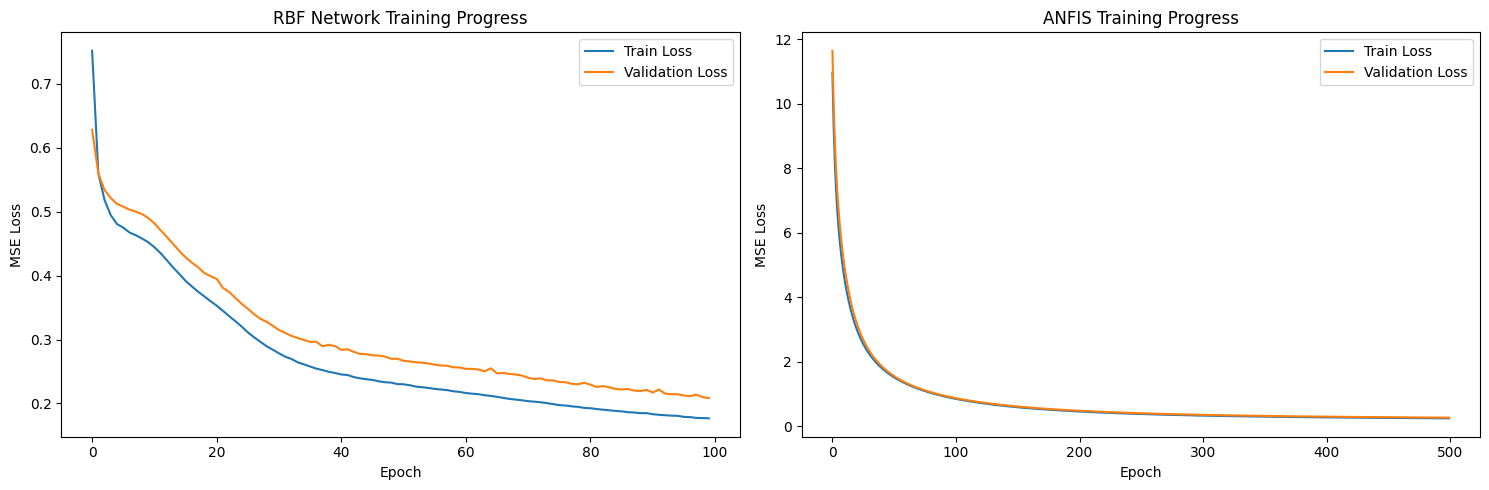

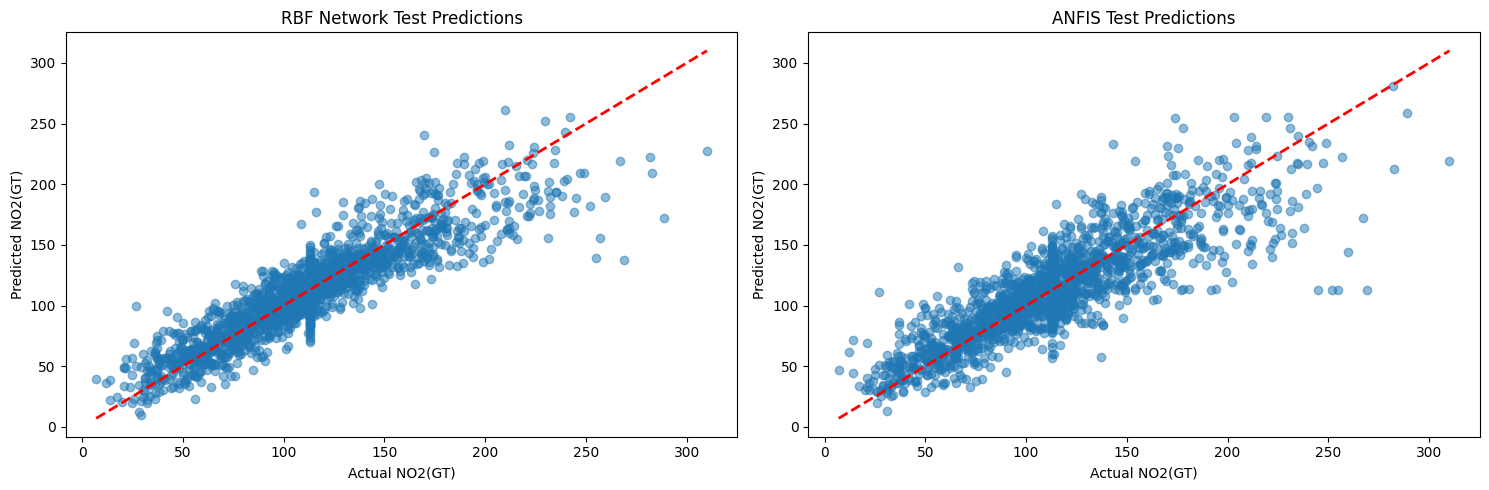

In [ ]:
# Evaluate models on test set
print("\nEvaluating models on test set...")

# RBF Test Results
y_pred_rbf = rbf_model.predict(X_test)
y_test_reshaped = y_test.reshape(-1, 1)
y_pred_rbf_unscaled = scaler_y.inverse_transform(y_pred_rbf)
y_test_unscaled = scaler_y.inverse_transform(y_test_reshaped)

rmse_rbf = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_rbf_unscaled))
r2_rbf = r2_score(y_test_unscaled, y_pred_rbf_unscaled)

print("\nRBF Network Test Results:")
print(f"Test RMSE: {rmse_rbf:.2f}")
print(f"Test R2 Score: {r2_rbf:.3f}")

# ANFIS Test Results
y_pred_anfis = anfis_model.predict(X_test).reshape(-1, 1)
y_pred_anfis_unscaled = scaler_y.inverse_transform(y_pred_anfis)

rmse_anfis = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_anfis_unscaled))
r2_anfis = r2_score(y_test_unscaled, y_pred_anfis_unscaled)

print("\nANFIS Test Results:")
print(f"Test RMSE: {rmse_anfis:.2f}")
print(f"Test R2 Score: {r2_anfis:.3f}")

# Plot training and validation losses
plt.figure(figsize=(15, 5))

# RBF losses
plt.subplot(121)
plt.plot(history.train_losses, label='Train Loss')
plt.plot(history.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('RBF Network Training Progress')
plt.legend()

# ANFIS losses
plt.subplot(122)
plt.plot(anfis_model.train_losses, label='Train Loss')
plt.plot(anfis_model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('ANFIS Training Progress')
plt.legend()

plt.tight_layout()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(15, 5))

# RBF predictions
plt.subplot(121)
plt.scatter(y_test_unscaled, y_pred_rbf_unscaled, alpha=0.5)
plt.plot([y_test_unscaled.min(), y_test_unscaled.max()],
         [y_test_unscaled.min(), y_test_unscaled.max()],
         'r--', lw=2)
plt.xlabel('Actual NO2(GT)')
plt.ylabel('Predicted NO2(GT)')
plt.title('RBF Network Test Predictions')

# ANFIS predictions
plt.subplot(122)
plt.scatter(y_test_unscaled, y_pred_anfis_unscaled, alpha=0.5)
plt.plot([y_test_unscaled.min(), y_test_unscaled.max()],
         [y_test_unscaled.min(), y_test_unscaled.max()],
         'r--', lw=2)
plt.xlabel('Actual NO2(GT)')
plt.ylabel('Predicted NO2(GT)')
plt.title('ANFIS Test Predictions')

plt.tight_layout()
plt.show()